In [ ]:
# 导入相关的包
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

步骤一：下载手写数字数据集，进行初步的数据可视化和统计

训练集的样本数：60000，测试集的样本数：10000
输入图像的大小：28*28
训练集的图像类别分布： Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


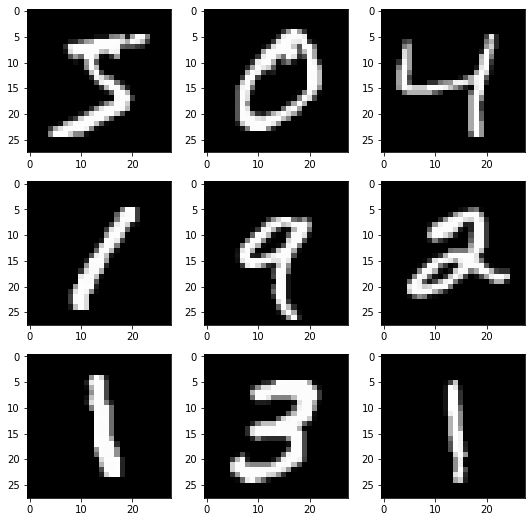

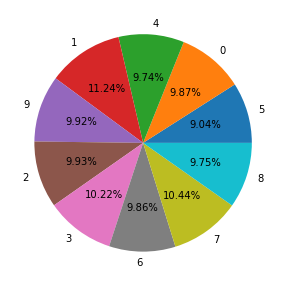

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # 下载数据集

# 可视化训练集的前9张图片
plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.savefig('sample.png', bbox_inches='tight', dpi=300)

print(f'训练集的样本数：{x_train.shape[0]}，测试集的样本数：{x_test.shape[0]}')
print(f'输入图像的大小：{x_train.shape[1]}*{x_train.shape[2]}')
label_cnt = Counter(y_train)  # 统计
print('训练集的图像类别分布：', label_cnt)
plt.figure(figsize=(5, 5))
plt.pie(x=label_cnt.values(),
        labels=label_cnt.keys(),
        autopct='%.2f%%')
plt.savefig('label_distribution.png', bbox_inches='tight', dpi=300)

步骤二：数据预处理

In [3]:
num_class = len(label_cnt)

x_train = np.expand_dims(x_train, axis=-1) # (28, 28)扩展为(28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)

# expand_dims
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255  # 规范化，将像素值缩至0-1之间
x_test /= 255

y_train = tf.keras.utils.to_categorical(y_train, num_class)  # 将标签向量转化为one-hot形式的向量
y_test = tf.keras.utils.to_categorical(y_test, num_class)

步骤三：模型搭建

In [4]:
model = tf.keras.models.Sequential()  # 序列化模型
model.add(tf.keras.layers.Conv2D(32, 3, input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Activation('relu'))  # relu 非线性激活函数
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout 将部分节点的激活值置为0防止过拟合
model.add(tf.keras.layers.Conv2D(64, 3,))
model.add(tf.keras.layers.Activation('relu'))  
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.1)) 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(num_class))  # 由一个全连接层，10维输出，看作是每一类的概率值
model.add(tf.keras.layers.Activation('softmax'))  # softmax 激活函数用于分类，对概率进行归一化

model.summary()  # 查看模型架构
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])  # 定义模型训练细节，包括交叉熵损失函数，Adam优化器和准确率评价指标

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

步骤四：训练模型

In [5]:
h = model.fit(x_train, y_train, batch_size=128, nb_epoch=10, validation_data=(x_test, y_test))
model.save("cnn_model.h5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.2559 - accuracy: 0.9236 - val_loss: 0.0714 - val_accuracy: 0.9784
Epoch 2/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.0444 - val_accuracy: 0.9850
Epoch 3/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0551 - accuracy: 0.9833 - val_loss: 0.0392 - val_accuracy: 0.9876
Epoch 4/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0437 - accuracy: 0.9865 - val_loss: 0.0335 - val_accuracy: 0.9895
Epoch 5/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0365 - accuracy: 0.9884 - val_loss: 0.0293 - val_accuracy: 0.9902
Epoch 6/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0323 - accuracy: 0.9896 - val_loss: 0.0276 - val_accuracy: 0.9902
Epoch 7/10
60000/60000 [==============================]

步骤五：评估模型

In [6]:
reconstructed_model = tf.keras.models.load_model("cnn_model.h5")
test_loss, test_acc = reconstructed_model.evaluate(x_test, y_test, verbose=0)
print(f'测试集损失值: {test_loss}, 测试集准确率: {test_acc}')

y_pred = reconstructed_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

测试集损失值: 0.02625542613324069, 测试集准确率: 0.9919999837875366
[[ 977    1    0    0    0    0    0    1    1    0]
 [   0 1133    0    0    0    0    0    0    1    1]
 [   0    0 1023    2    2    0    0    4    0    1]
 [   0    0    0 1007    0    1    0    0    2    0]
 [   0    0    1    0  972    0    1    1    0    7]
 [   2    0    0    7    0  879    1    0    1    2]
 [   5    2    1    1    1    1  942    0    5    0]
 [   0    2    1    2    0    0    0 1019    0    4]
 [   3    0    2    1    0    2    0    0  964    2]
 [   0    0    0    0    2    2    0    1    0 1004]]


步骤六：可视化结果

In [7]:
print(h.history.keys())
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


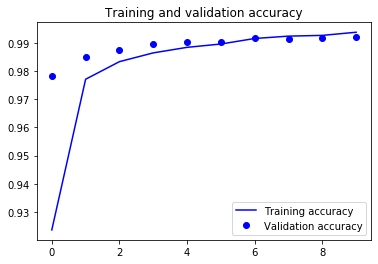

In [8]:
plt.figure()
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('accuracy.png', bbox_inches='tight', dpi=300)

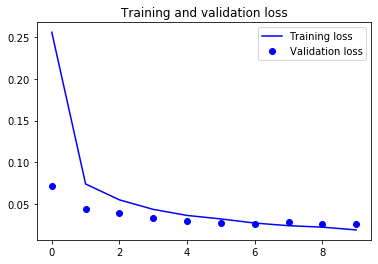

In [9]:
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png', bbox_inches='tight', dpi=300)

步骤七：实际图片预测

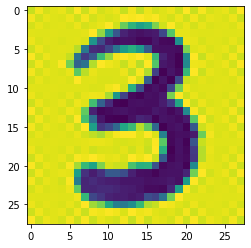

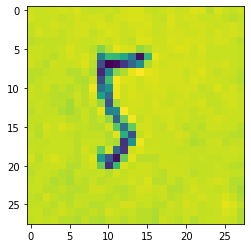

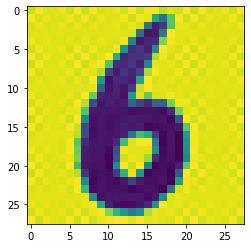

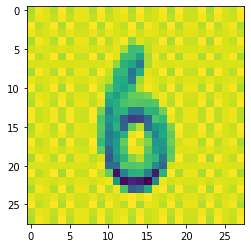

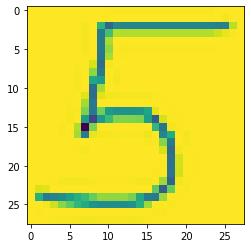

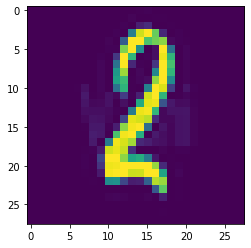

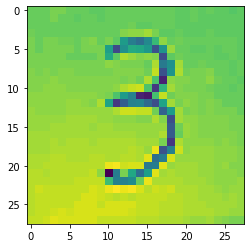

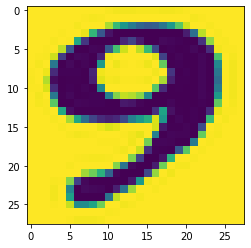

In [10]:
file_path = "./cnn_pic"
pic_name_list = os.listdir(file_path)
pic_list = list()
for pic in pic_name_list:
    # 以黑白方式读取图片  
    img = Image.open(os.path.join(file_path, pic)).convert('L')  # 转化为黑白图片
    img = img.resize((28,28),Image.ANTIALIAS)
    pic_list.append(img)
    plt.figure()
    plt.imshow(np.asarray(img))

In [11]:
for pic in pic_list:
    img = np.reshape(pic, (28, 28, 1)) / 255.
    x = np.array([1 - img])  
    # API refer: https://keras.io/models/model/  
    y = model.predict(x) 
    print(y[0])  
    print("----------> Predict digit", np.argmax(y[0])) 
    print("=================")

[5.0507143e-15 1.2374147e-11 1.3397415e-11 1.0000000e+00 3.3533826e-13
 2.9374798e-09 1.5210359e-15 6.1242074e-09 3.2451539e-10 3.1839109e-10]
----------> Predict digit 3
[0.03698309 0.01868131 0.03658675 0.00939806 0.06040895 0.27095318
 0.03558745 0.22356926 0.27292055 0.03491135]
----------> Predict digit 8
[1.1271505e-07 1.8361661e-08 2.4597531e-08 7.3743842e-09 7.9421191e-08
 1.4516318e-05 9.9994910e-01 3.4509586e-11 3.6223733e-05 1.6081595e-08]
----------> Predict digit 6
[0.04423282 0.00875107 0.05359692 0.04470467 0.0088074  0.11640622
 0.46493968 0.00131112 0.24744038 0.00980965]
----------> Predict digit 6
[6.1145256e-06 5.4942477e-05 1.8329352e-05 7.5585661e-03 4.2408509e-03
 9.8281109e-01 2.1285480e-03 2.5888288e-03 3.8950131e-04 2.0335283e-04]
----------> Predict digit 5
[1.73087001e-01 3.72882863e-03 2.27759220e-02 7.05630009e-06
 7.12085068e-01 1.22030644e-04 7.71584287e-02 3.63576598e-03
 7.30920816e-03 9.05957568e-05]
----------> Predict digit 4
[0.08556519 0.07543468 